# Use Pandas to Sort event arrivals csv files 
## according to max SNR value

##  Fei Zhang
### 2018-07-26

In [1]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'SNR', 'P_or_S']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:
inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'

residual_cutoff=10.0
sortedfile='sortedfile_S.csv'
sortedfile2= 'sortedfile2_S.csv'

inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/seismic_events_arrivals_P_0.csv'
#inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/tempworks/outfile_P.csv'
residual_cutoff=5.0
sortedfile='sortedfile_P.csv'
sortedfile2= 'sortedfile2_P.csv'


In [5]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello world!')

# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    print('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    log.debug("Number of records in initial CSV file = %s", cluster_data.shape[0])
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    log.debug("Number of records after residual cutoff = %s", cluster_data.shape[0])
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    
    log.debug("Number of records before drop_duplicates = %s", final_df.shape[0])
    
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    log.debug("Number of records in final pdf = %s", final_df.shape[0])
    return final_df


2018-07-26 16:22:57,757 | INFO : Hello world!


In [6]:
finalpdf = sort2(inputcsv,sortedfile,residual_cutoff)

Filtering arrivals.
2018-07-26 16:22:57,974 | DEBUG : Number of records in initial CSV file = 61721
2018-07-26 16:22:57,983 | DEBUG : Number of records after residual cutoff = 55208
2018-07-26 16:22:58,051 | INFO : Sorting arrivals.
2018-07-26 16:22:58,228 | DEBUG : Number of records before drop_duplicates = 21015
2018-07-26 16:22:58,687 | DEBUG : Number of records in final pdf = 20217


In [7]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
59635,11724,33247,-0.65,1000000,-156.7609,57.8058,0.8516,125.9880,-2.0497,756.913111,84.995550,SANI,7.998570,1
36014,12404,41192,-3.60,1000000,163.1160,55.8446,4.9000,151.1690,-23.8421,728.187172,80.333831,GD1S,45.106867,1
22255,12687,41529,-0.85,1000000,86.3612,54.5181,0.0000,128.2960,-25.0362,767.631732,87.327802,WRKA,5.338475,1
48388,13047,39735,-3.45,1000000,85.9557,54.3016,0.0000,134.3650,-19.9250,753.668826,84.985918,WC2,18.897711,1
25845,13048,36852,-0.25,1000000,87.3762,54.1473,0.0000,130.8423,-12.4667,709.382878,76.107566,DPH,10.647652,1


In [8]:
finalpdf.shape

(20217, 14)

In [9]:
#sort again
pdf2=sort2(sortedfile, sortedfile2, residual_cutoff )

Filtering arrivals.
2018-07-26 16:22:58,807 | DEBUG : Number of records in initial CSV file = 20217
2018-07-26 16:22:58,812 | DEBUG : Number of records after residual cutoff = 20217
2018-07-26 16:22:58,814 | INFO : Sorting arrivals.
2018-07-26 16:22:58,883 | DEBUG : Number of records before drop_duplicates = 20217
2018-07-26 16:22:59,249 | DEBUG : Number of records in final pdf = 20217


In [10]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
0,11724,33247,-0.65,1000000,-156.7609,57.8058,0.000852,125.9880,-2.0497,756.913111,84.995550,SANI,7.998570,1
1,12404,41192,-3.60,1000000,163.1160,55.8446,0.004900,151.1690,-23.8421,728.187172,80.333831,GD1S,45.106867,1
2,12687,41529,-0.85,1000000,86.3612,54.5181,0.000000,128.2960,-25.0362,767.631732,87.327802,WRKA,5.338475,1
3,13047,39735,-3.45,1000000,85.9557,54.3016,0.000000,134.3650,-19.9250,753.668826,84.985918,WC2,18.897711,1
4,13048,36852,-0.25,1000000,87.3762,54.1473,0.000000,130.8423,-12.4667,709.382878,76.107566,DPH,10.647652,1


In [11]:
pdf2.shape

(20217, 14)

2018-07-26 16:22:59,376 | DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/g/data/ha3/fxz547/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


<Figure size 432x288 with 0 Axes>

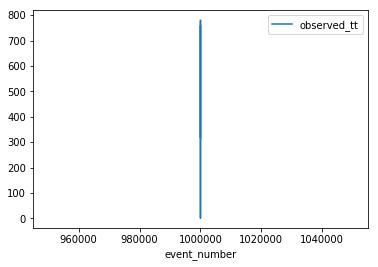

In [12]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

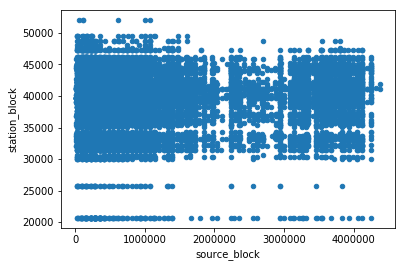

In [13]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

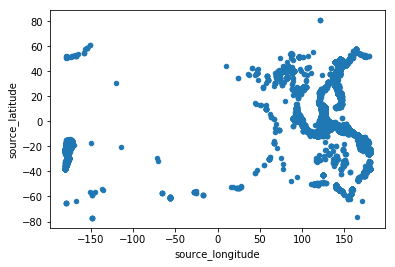

In [14]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

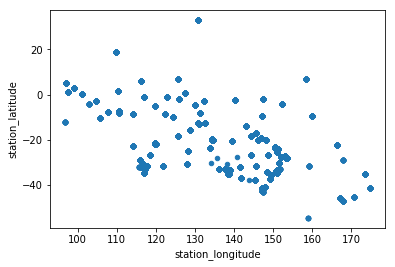

In [15]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')

In [16]:
 med = pdf2.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [17]:
med.head()

,source_block,station_block,observed_tt
0,11724,33247,756.913111
1,12404,41192,728.187172
2,12687,41529,767.631732
3,13047,39735,753.668826
4,13048,36852,709.382878


In [18]:
med.shape

(20217, 3)

In [19]:
med2 = pdf2.groupby(
        by=['source_block', 'station_block'] )['SNR'].max().reset_index() # use a seq index:0,1,2,.

In [20]:
med2.head()

,source_block,station_block,SNR
0,11724,33247,7.998570
1,12404,41192,45.106867
2,12687,41529,5.338475
3,13047,39735,18.897711
4,13048,36852,10.647652


In [21]:
med2.shape

(20217, 3)

In [22]:
pdf2.loc[2]

source_block           12687
station_block          41529
residual               -0.85
event_number         1000000
source_longitude     86.3612
source_latitude      54.5181
source_depth               0
station_longitude    128.296
station_latitude    -25.0362
observed_tt          767.632
locations2degrees    87.3278
station_code            WRKA
SNR                  5.33848
P_or_S                     1
Name: 2, dtype: object

In [23]:
pdf2.iloc[1]

source_block           12404
station_block          41192
residual                -3.6
event_number         1000000
source_longitude     163.116
source_latitude      55.8446
source_depth          0.0049
station_longitude    151.169
station_latitude    -23.8421
observed_tt          728.187
locations2degrees    80.3338
station_code            GD1S
SNR                  45.1069
P_or_S                     1
Name: 1, dtype: object

In [24]:
pdf2.describe()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,SNR,P_or_S
count,2.021700e+04,20217.000000,20217.000000,20217.0,20217.000000,20217.000000,20217.000000,20217.000000,20217.000000,20217.000000,20217.000000,20217.000000,20217.0
mean,1.025126e+06,39479.035663,0.100183,1000000.0,74.338275,-4.403576,0.152888,134.931952,-19.241482,378.989894,34.759751,12.589794,1.0
std,1.175646e+06,4374.404155,1.743226,0.0,126.745451,20.655543,0.181127,13.855362,12.117398,168.493896,19.414958,29.405383,0.0
min,1.172400e+04,20652.000000,-5.000000,1000000.0,-179.995400,-77.188300,0.000000,96.835000,-54.498200,1.299029,0.048722,1.501894,1.0
25%,2.287350e+05,37212.000000,-1.000000,1000000.0,95.765500,-18.159400,0.031130,128.059000,-26.636900,272.284353,20.596656,5.117718,1.0
50%,4.875810e+05,40081.000000,0.250000,1000000.0,127.165000,-6.174000,0.070841,134.387000,-20.557200,377.550082,32.993765,7.079041,1.0
75%,1.277457e+06,42265.000000,1.250000,1000000.0,147.847200,2.625500,0.193268,145.692000,-12.686200,489.041211,46.509515,11.448977,1.0
max,4.381382e+06,52000.000000,5.000000,1000000.0,179.988600,80.800000,0.668000,174.705000,32.809000,779.922265,89.988315,1307.319956,1.0


In [25]:
pdf2.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215,
            20216],
           dtype='int64', length=20217)

In [26]:
pdf2.index=pdf2.event_number

In [27]:
pdf2.index

Int64Index([1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
            1000000, 1000000, 1000000,
            ...
            1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
            1000000, 1000000, 1000000],
           dtype='int64', name='event_number', length=20217)

In [28]:
pdf2.tail(n=5)

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
event_number,,,,,,,,,,,,,,
1000000,4252142,41175,1.70,1000000,-179.2167,-21.3814,0.650,133.970,-23.6652,426.822943,43.111803,AS07,3.690084,1
1000000,4253939,44792,-2.60,1000000,178.3830,-25.6856,0.650,150.874,-34.4070,275.011179,25.260917,WOLH,12.666174,1
1000000,4317660,41192,-0.15,1000000,178.7000,-23.4676,0.662,151.169,-23.8421,276.342134,25.180727,GD1S,30.381803,1
1000000,4381382,41175,1.10,1000000,-179.0704,-19.6998,0.668,133.970,-23.6652,429.152508,43.627759,AS07,7.415461,1
1000000,4381382,41910,-1.30,1000000,-179.0704,-19.6998,0.668,148.758,-26.4853,318.822995,30.275572,RMQ,5.494720,1


In [29]:
pdf2.iloc[1]  # now .loc[2] does not work

source_block           12404
station_block          41192
residual                -3.6
event_number         1000000
source_longitude     163.116
source_latitude      55.8446
source_depth          0.0049
station_longitude    151.169
station_latitude    -23.8421
observed_tt          728.187
locations2degrees    80.3338
station_code            GD1S
SNR                  45.1069
P_or_S                     1
Name: 1000000, dtype: object

In [30]:
#pdf2.loc[215]